In [1]:
import pandas as pd
import numpy as np 
import sqlite3 

# Data Generation (Simulating a real telco dataset)
np.random.seed(42)
n_samples = 1000

data = {
    'CustomerID': range(1,n_samples+1),
    'Gender': np.random.choice(['Male','Female'],n_samples),
    'Age': np.random.randint(18,70,n_samples),
    'MonthlyCharges': np.random.normal(70,15,n_samples).round(2), # Normal dist, mean=70, std=15
    'Tenure': np.random.randint(1,72,n_samples), # Months with the company
    'Contract': np.random.choice(['Month to month','One year','Two year'],n_samples),
    'Churn': np.random.choice([0,1],n_samples,p=[0.75,0.25]) # 0: Stayed, 1: Churned
}

df_raw = pd.DataFrame(data)


In [2]:
# SQL SETUP (Creating a local SQLite database)
# Creating a database named 'telco_project.db'

conn = sqlite3.connect('telco_project.db')

#Writing the raw datafrane to a sql table named customers

df_raw.to_sql('customers',conn, if_exists='replace', index = False)

print("Database created and data loaded successfully! ")

Database created and data loaded successfully! 


In [3]:
# DATA EXTRACTION WITH SQL
# Scenario: We need to analyze customers with monthly  charges greater than $80 

query = """ 
SELECT *
FROM customers
WHERE MonthlyCharges > 80
"""

#Executing the query and saving to a dataframe 
df_analysis = pd.read_sql(query,conn)

#closing the connection 
conn.close()

# Displaying results
print(f"\nNumber of rows fetched via SQL: {len(df_analysis)}")
df_analysis.head()




Number of rows fetched via SQL: 269


,CustomerID,Gender,Age,MonthlyCharges,Tenure,Contract,Churn
0,6,Female,45,100.15,56,Two year,0
1,12,Male,23,96.92,56,Two year,1
2,16,Male,64,87.83,20,Month to month,0
3,17,Female,42,107.90,19,Two year,0
4,20,Male,47,85.66,18,Month to month,0


In [4]:
import scipy.stats as stats 
import seaborn as sns
import matplotlib.pyplot as plt

group_churn = df_raw[df_raw['Churn']==1]['MonthlyCharges']
group_stay = df_raw[df_raw['Churn']==0]['MonthlyCharges']

print(f"Kayıp Müşterilerin Aylık Harcama Ortalaması: {group_churn.mean():.2f}")
print("-" * 30)
print(f"Kalan Müşterilerin Aylık Harcama Ortalaması: {group_stay.mean():.2f}")

Kayıp Müşterilerin Aylık Harcama Ortalaması: 71.24
------------------------------
Kalan Müşterilerin Aylık Harcama Ortalaması: 71.18


In [5]:
#Normallik varsayımı kontrolü

stat_churn, p_churn = stats.shapiro(group_churn)
stat_stay,p_stay = stats.shapiro(group_stay)

print(f"Kayıp Müşterilerin P değeri: {p_churn:.4f}")
print(f"Kalan Müşterilerin P değeri: {p_stay:.5f}")

Kayıp Müşterilerin P değeri: 0.3621
Kalan Müşterilerin P değeri: 0.88696


In [6]:
# Hipotez testi seçimi ve uygulama

alpha = 0.05

if p_churn > alpha and p_stay > alpha:
    print("Veri normal dağılıyor Bağımsız iki örneklem t testi uygulanıyor.")
    test_stat, p_value = stats.ttest_ind(group_churn,group_stay)
else:
    print("Veri normal dağılmıyor Mann Whitney U testi uygulanıyor")
    test_stat, p_value = stats.mannwhitneyu(group_churn,group_stay)

print("-" * 30)
print(f"Test İstatistiği: {test_stat:.4f}")
print(f"P-Değeri (P-value): {p_value:.4f}")

if p_value < alpha:
    print("\nSONUÇ: H0 Reddedildi! 🚩")
    print("Yorum: İki grup arasında istatistiksel olarak ANLAMLI bir fark vardır.")
else:
    print("\nSONUÇ: H0 Reddedilemedi.")
    print("Yorum: Gözlemlenen fark şans eseri olabilir.")



Veri normal dağılıyor Bağımsız iki örneklem t testi uygulanıyor.
------------------------------
Test İstatistiği: 0.0506
P-Değeri (P-value): 0.9597

SONUÇ: H0 Reddedilemedi.
Yorum: Gözlemlenen fark şans eseri olabilir.


C:\Users\hasan zorlu\AppData\Local\Temp\ipykernel_22148\1963603383.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df_raw, palette="Set2")


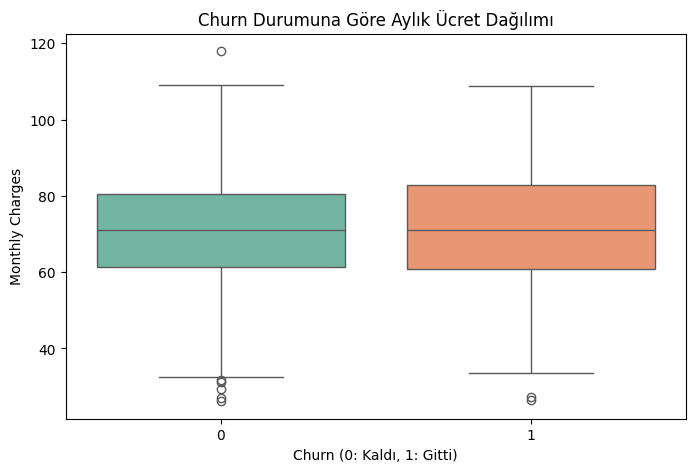

In [7]:
#  Görselleştirme (Boxplot) 
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_raw, palette="Set2")
plt.title('Churn Durumuna Göre Aylık Ücret Dağılımı')
plt.xlabel('Churn (0: Kaldı, 1: Gitti)')
plt.ylabel('Monthly Charges')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Veri önişeme (Data preprocessing)
#Gereksiz sütunları atalım (CustomerID)

df_model = df_raw.drop(['CustomerID'], axis = 1)

# kategorik değişkenleri sayıya çevirelim  (one-hot encoding / dummy variables)

df_encoded = pd.get_dummies(df_model, drop_first = True) #drop_first = True Multicollinearity (Çoklu Bağlantı) sorununu önlemek için bir kategoriyi baz alır.



In [9]:
# bağımlı (y) ve bağımsız değişkenleri (X) ayıralım

X = df_encoded.drop('Churn',axis = 1)
y = df_encoded['Churn']

# Train - Test split (%80 eğitim verisi %20 test verisi)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

#Model kurulumu (logistic regression )

#model oluştur

model = LogisticRegression(max_iter = 1000) # max_iter = 1000 itelasyon sayısı default değeri 100

# modeli eğit (fit)

model.fit(X_train, y_train)

# tahmin (prediction)

y_pred = model.predict(X_test)


In [10]:
# başarı metrikleri (evaluation)

print("Model doğruluk oranı (Accuracy):", accuracy_score(y_test, y_pred))
print("\nKarmaşıklık matrisi (Confusion matrix):")
print(confusion_matrix(y_test, y_pred))
print("\nSınıflandırma raporu (Classification report):")
print(classification_report(y_test, y_pred))

Model doğruluk oranı (Accuracy): 0.775

Karmaşıklık matrisi (Confusion matrix):
[[155   0]
 [ 45   0]]

Sınıflandırma raporu (Classification report):
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       155
           1       0.00      0.00      0.00        45

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.60      0.78      0.68       200



C:\Users\hasan zorlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hasan zorlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hasan zorlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [11]:
# Doğruluk oranı 0.775 olmasına rağmen kayıp müşterileri doğru tahmin edemiyor 

# class_weight = 'balanced' azınlık sınıfına otomatik olarak yüksek ağırlık verir.

model_balanced = LogisticRegression(max_iter = 1000, class_weight = 'balanced')

model_balanced.fit(X_train, y_train)

y_pred_balanced = model_balanced.predict(X_test)

# 4. SONUÇLAR
print("--- Class Weighting (Ağırlıklandırma) Sonrası ---")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))


--- Class Weighting (Ağırlıklandırma) Sonrası ---
Accuracy: 0.525

Confusion Matrix:
 [[81 74]
 [21 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.52      0.63       155
           1       0.24      0.53      0.34        45

    accuracy                           0.53       200
   macro avg       0.52      0.53      0.48       200
weighted avg       0.67      0.53      0.56       200



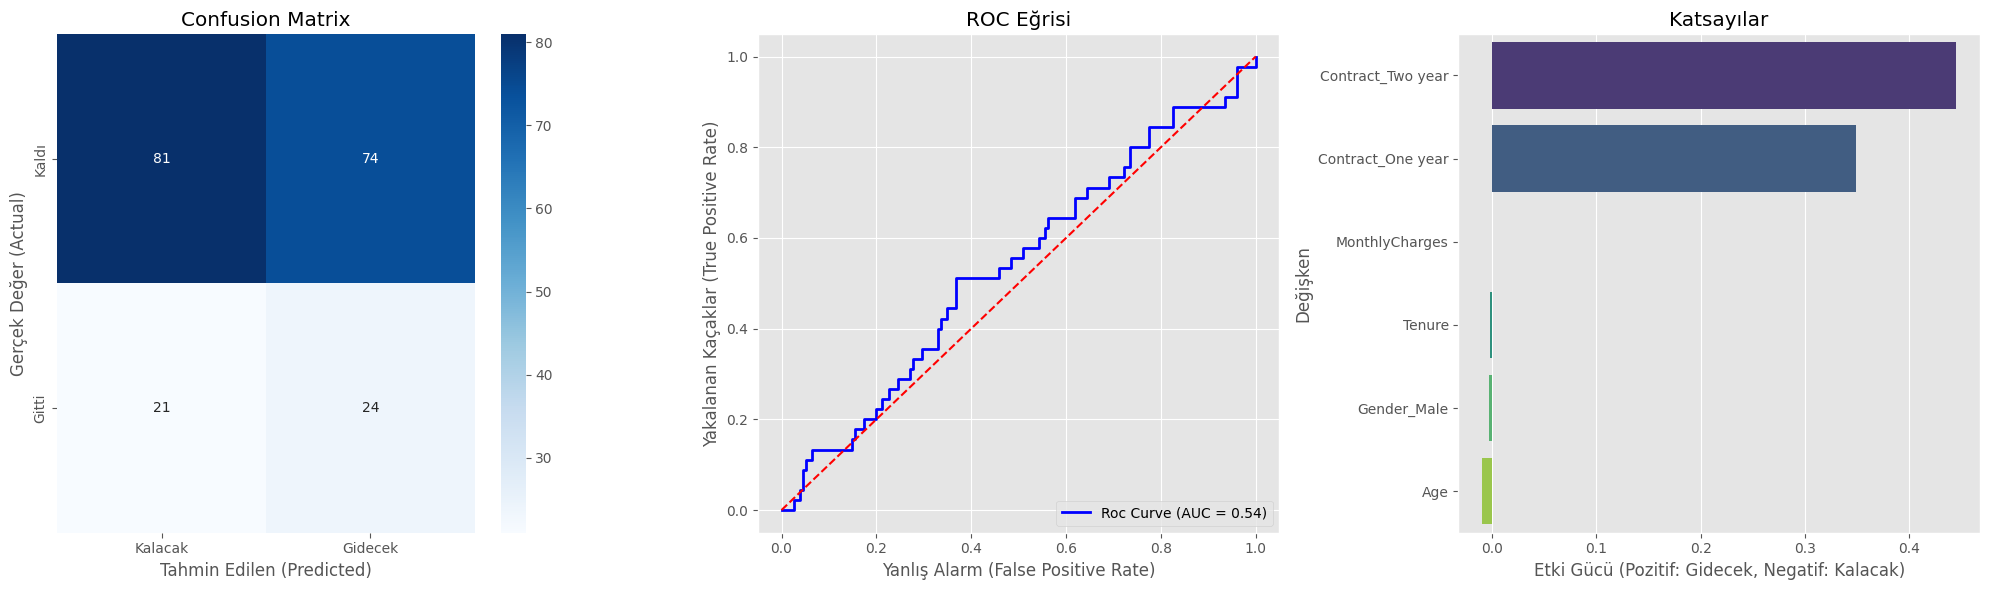

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

plt.style.use('ggplot')
fig, ax = plt.subplots(1,3, figsize=(20,6))

#confusion matrix

sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot = True, fmt = 'd', cmap= 'Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Tahmin Edilen (Predicted)')
ax[0].set_ylabel('Gerçek Değer (Actual)')
ax[0].set_xticklabels(['Kalacak', 'Gidecek'])
ax[0].set_yticklabels(['Kaldı','Gitti'])

# ROC eğrisi (Receiver Operating Characteristic)
# Modelin ayırt etme gücünü (Sensitivity vs Specificity) gösterir.
# Çapraz çizgi (kırmızı) %50 şans başarısıdır. Mavi çizgi ne kadar yukarıdaysa o kadar iyi.

y_prob = model_balanced.predict_proba(X_test)[:,1] # olasılık değerlerini alır
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color = 'blue', lw = 2, label = f'Roc Curve (AUC = {roc_auc:.2f})')
ax[1].plot([0,1],[0,1], color = 'red', linestyle = '--') # şans çizgisi
ax[1].set_title('ROC Eğrisi')
ax[1].set_xlabel('Yanlış Alarm (False Positive Rate)')
ax[1].set_ylabel('Yakalanan Kaçaklar (True Positive Rate)')
ax[1].legend(loc="lower right")

# katsayıların önemi 
# Hangi değişkenin Churn üzerinde ne kadar etkisi var? (Lojistik Regresyon Katsayıları)

coeffs = pd.DataFrame({
    'Değişken': X.columns,
    'Katsayı (Etki)': model_balanced.coef_[0]
}).sort_values(by = 'Katsayı (Etki)', ascending = False)

sns.barplot(x='Katsayı (Etki)', y='Değişken', data=coeffs, ax=ax[2], palette='viridis', hue='Değişken', legend=False)
ax[2].set_title('Katsayılar')
ax[2].set_xlabel('Etki Gücü (Pozitif: Gidecek, Negatif: Kalacak)')

plt.tight_layout()
plt.show()

In [13]:
import joblib

# MODELİ KAYDETME (Pickling)

joblib.dump(model_balanced, 'churn_modeli.pkl')
print("Model başarıyla paketlendi ve 'churn_modeli.pkl' olarak kaydedildi!")

Model başarıyla paketlendi ve 'churn_modeli.pkl' olarak kaydedildi!


In [14]:
# Kaydettiğimiz dosyayı geri çağırıyoruz.
loaded_model = joblib.load('churn_modeli.pkl')

# YENİ MÜŞTERİ VERİSİ (Senaryo)
# Ahmet Bey: 45 yaşında, 72 aydır bizde (Sadık), 2 Yıllık kontratı var.
# Sütunlar: [Age, Tenure, MonthlyCharges, Gender_Male, Contract_One year, Contract_Two year]
# Not: One-Hot Encoding yaptığımız için değerleri 0 ve 1 olarak giriyoruz.
yeni_musteri = [[45, 72, 90.5, 1, 0, 1]] 

# 4. TAHMİN YAPMA
sonuc = loaded_model.predict(yeni_musteri)
olasilik = loaded_model.predict_proba(yeni_musteri)

print("-" * 30)
print(" Müşteri: Ahmet Bey")
print(f" Terk Etme İhtimali: %{olasilik[0][1]*100:.2f}")

if sonuc[0] == 1:
    print(" SONUÇ: RİSKLİ! Müşteri gidebilir. (Churn)")
else:
    print(" SONUÇ: GÜVENLİ. Müşteri kalıcı görünüyor.")
print("-" * 30)

------------------------------
 Müşteri: Ahmet Bey
 Terk Etme İhtimali: %50.99
 SONUÇ: RİSKLİ! Müşteri gidebilir. (Churn)
------------------------------


C:\Users\hasan zorlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\hasan zorlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
